In [29]:
#必要なセットを読み込み
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [30]:
#machine learning用のセット読み込み
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn

In [31]:
#ファイルの読み込み
titanic_df = pd.read_csv("train.csv")
test_df    = pd.read_csv("test.csv")

#データを表示してみる
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [32]:
#データの詳細
titanic_df.info()
print()
test_df.info()
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null floa

In [33]:
# 各特徴量の欠損値をカウント
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

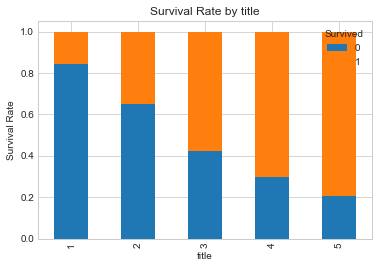

In [34]:
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'
#

def title_map(title):
    if title in ['Mr']:
        return 1
    elif title in ['Master']:
        return 3
    elif title in ['Ms','Mlle','Miss']:
        return 4
    elif title in ['Mme','Mrs']:
        return 5
    else:
        return 2
    
titanic_df['title'] = titanic_df['Name'].apply(get_title).apply(title_map)   
test_df['title'] = test_df['Name'].apply(get_title).apply(title_map)
title_xt = pd.crosstab(titanic_df['title'], titanic_df['Survived'])
title_xt_pct = title_xt.div(title_xt.sum(1).astype(float), axis=0)

title_xt_pct.plot(kind='bar', 
                  stacked=True, 
                  title='Survival Rate by title')
plt.xlabel('title')
plt.ylabel('Survival Rate')

In [35]:
#不要な列を削除、これらの列は分析や予測に不要
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df    = test_df.drop(['Name','Ticket'], axis=1)

In [36]:
#"Embarked"補完
#titanic_dfでのみ、2つの欠損値を 最も発生した値"S"で埋める
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")

# plot
#sns.factorplot('Embarked','Survived', data=titanic_df,size=4,aspect=3)

#fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# sns.factorplot('Embarked',data=titanic_df,kind='count',order=['S','C','Q'],ax=axis1)
# sns.factorplot('Survived',hue="Embarked",data=titanic_df,kind='count',order=[1,0],ax=axis2)
#sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
#sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

#embarkeでグループ化。Embarkedで各値の生き残った乗客の平均値を取得
#embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
#sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

#予測に、Embarked columnを考慮する
#"S" をダミー変数として削除する 
#"C" & "Q"を残す。 since they seem to have a good rate for Survival.

# あるいは、Embarked columnをダミー変数化にするために単に落とす。
# なぜなら、Embarkedは予測に使えないように思われる。
embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)
#print(embark_dummies_titanic)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)
#print(titanic_df)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

In [37]:
# Age impute
titanic_df['Age'] = titanic_df.groupby(['Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))
test_df['Age'] = test_df.groupby(['Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))

In [55]:
# Age 

#fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
#axis1.set_title('Original Age values - Titanic')
#axis2.set_title('New Age values - Titanic')

# axis3.set_title('Original Age values - Test')
# axis4.set_title('New Age values - Test')

# get average, std, and number of NaN values in titanic_df
#average_age_titanic   = titanic_df["Age"].mean()
#std_age_titanic       = titanic_df["Age"].std()
#count_nan_age_titanic = titanic_df["Age"].isnull().sum()

# get average, std, and number of NaN values in test_df
#average_age_test   = test_df["Age"].mean()
#std_age_test       = test_df["Age"].std()
#count_nan_age_test = test_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
#rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
#rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# plot original Age values
# NOTE: drop all null values, and convert to int
#titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)
# test_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
#titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_1
#test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)

titanic_df.loc[ titanic_df['Age'] <= 16, 'Age'] = 0
titanic_df.loc[(titanic_df['Age'] > 16) & (titanic_df['Age'] <= 32), 'Age'] = 1
titanic_df.loc[(titanic_df['Age'] > 32) & (titanic_df['Age'] <= 48), 'Age'] = 2
titanic_df.loc[(titanic_df['Age'] > 48) & (titanic_df['Age'] <= 64), 'Age'] = 3
titanic_df.loc[(titanic_df['Age'] > 64), 'Age'] = 4

test_df.loc[ test_df['Age'] <= 16, 'Age'] = 0
test_df.loc[(test_df['Age'] > 16) & (test_df['Age'] <= 32), 'Age'] = 1
test_df.loc[(test_df['Age'] > 32) & (test_df['Age'] <= 48), 'Age'] = 2
test_df.loc[(test_df['Age'] > 48) & (test_df['Age'] <= 64), 'Age'] = 3
test_df.loc[(test_df['Age'] > 64), 'Age'] = 4
        
# plot new Age Values
#titanic_df['Age'].hist(bins=70, ax=axis2)
# test_df['Age'].hist(bins=70, ax=axis4)

In [56]:
# .... continue with plot Age column

# peaks for survived/not survived passengers by their age
#facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
#facet.map(sns.kdeplot,'Age',shade= True)
#facet.set(xlim=(0, titanic_df['Age'].max()))
#facet.add_legend()

# average survived passengers by age
#fig, axis1 = plt.subplots(1,1,figsize=(18,4))
#average_age = titanic_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
#sns.barplot(x='Age', y='Survived', data=average_age)

In [58]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
#titanic_df.drop("Cabin",axis=1,inplace=True)
#test_df.drop("Cabin",axis=1,inplace=True)

In [59]:
# Family

# Instead of having two columns Parch & SibSp, 
# we can have only one column represent if the passenger had any family member aboard or not,
# Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not.
titanic_df['Family'] =  titanic_df["Parch"] + titanic_df["SibSp"]
titanic_df['Family'].loc[titanic_df['Family'] > 0] = 1
titanic_df['Family'].loc[titanic_df['Family'] == 0] = 0

test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0

# drop Parch & SibSp
titanic_df = titanic_df.drop(['SibSp','Parch'], axis=1)
test_df    = test_df.drop(['SibSp','Parch'], axis=1)

# plot
#fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=titanic_df,kind='count',ax=axis1)
#sns.countplot(x='Family', data=titanic_df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
#family_perc = titanic_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
#sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

#axis1.set_xticklabels(["With Family","Alone"], rotation=0)

KeyError: 'Parch'

In [60]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
#def get_person(passenger):
    #age,sex = passenger
    #return 'child' if age < 16 else sex
    
#titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
#test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
#titanic_df.drop(['Sex'],axis=1,inplace=True)
#test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
#person_dummies_titanic  = pd.get_dummies(titanic_df['Person'])
#person_dummies_titanic.columns = ['Child','Female','Male']
#person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

#person_dummies_test  = pd.get_dummies(test_df['Person'])
#print(person_dummies_test)
#person_dummies_test.columns = ['Child','Female','Male']
#person_dummies_test.drop(['Male'], axis=1, inplace=True)

#titanic_df = titanic_df.join(person_dummies_titanic)
#test_df    = test_df.join(person_dummies_test)

#fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
#sns.countplot(x='Person', data=titanic_df, ax=axis1)

# average of survived for each Person(male, female, or child)
#person_perc = titanic_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
#sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

#titanic_df.drop(['Person'],axis=1,inplace=True)
#test_df.drop(['Person'],axis=1,inplace=True)
sexes = sorted(titanic_df['Sex'].unique())
genders_mapping = dict(zip(sexes, range(0, len(sexes) + 1)))
titanic_df['Sex'] = titanic_df['Sex'].map(genders_mapping).astype(int)
test_df['Sex'] = test_df['Sex'].map(genders_mapping).astype(int)

In [43]:
# Pclass

# sns.factorplot('Pclass',data=titanic_df,kind='count',order=[1,2,3])
#sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanic_df,size=5)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
#pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
#pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
#pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

#pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
#pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
#pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

#titanic_df.drop(['Pclass'],axis=1,inplace=True)
#test_df.drop(['Pclass'],axis=1,inplace=True)

#titanic_df = titanic_df.join(pclass_dummies_titanic)
#test_df    = test_df.join(pclass_dummies_test)
titanic_df['age_class'] = titanic_df['Age'] * titanic_df['Pclass']
test_df['age_class'] = test_df['Age'] * test_df['Pclass']

In [45]:
titanic_df.head()
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,title,C,Q,Family,age_class
0,892,3,1,2,7.8292,1,0,1,0,6
1,893,3,0,2,7.0000,5,0,0,1,6
2,894,2,1,3,9.6875,1,0,1,0,6
3,895,3,1,1,8.6625,1,0,0,0,3
4,896,3,0,1,12.2875,5,0,0,1,3


In [46]:
# define training and testing sets

X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

In [47]:
#ロジスティクス回帰
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
logreg.score(X_train, Y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [48]:
##Support Vector Machines

#svc = SVC()
#svc.fit(X_train, Y_train)
#Y_pred_4 = svc.predict(X_test)
#svc.score(X_train, Y_train)

In [49]:
##Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred_4 = svc.predict(X_test)
svc.score(X_train, Y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [22]:
#grid_1 = { "n_estimators"      : [100],
#               "criterion"         : ["gini", "entropy"],
#               "max_features"      : ['sqrt','log2',0.2,0.5,0.8],
#               "max_depth"         : [3,4,6,10],
#               "min_samples_split" : [2, 5, 20,50] }
#RF=RandomForestClassifier()
#grid_search = sklearn.model_selection.GridSearchCV(RF, grid_1, n_jobs=-1, cv=5)
#grid_search.fit(X_train, Y_train)
#grid_search.best_params_

In [23]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=100)
#random_forest = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=10, max_features='sqrt', min_samples_split=5)

random_forest.fit(X_train, Y_train)

Y_pred_1 = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [24]:
Y_test = Y_pred_1
random_forest.score(X_test, Y_test)

NameError: name 'Y_pred_1' is not defined

In [25]:
#grid_2 = { "loss"          : ["deviance","exponential"],
 #              "n_estimators"  : [100],
 #             "max_features"      : ['sqrt','log2',0.2,0.5,0.8]}
#GB=GradientBoostingClassifier()
#grid_search = sklearn.model_selection.GridSearchCV(GB, grid_2, n_jobs=-1, cv=5)
#grid_search.fit(X_train, Y_train)
#grid_search.best_params_

In [26]:
#gradient_boost = GradientBoostingClassifier(n_estimators=100,loss='exponential',max_features='log2')
gradient_boost = GradientBoostingClassifier(n_estimators=100)
gradient_boost.fit(X_train, Y_train)

Y_pred_2 = gradient_boost.predict(X_test)

gradient_boost.score(X_train, Y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [27]:
#grid_3 = { "n_estimators" : [100],
              # "criterion"         : ["gini", "entropy"],
             #  "max_features"      : ['sqrt','log2',0.2,0.5,0.8],
             #  "max_depth"         : [4,7,10],
            #   "min_samples_split" : [2, 5, 10] }
#ET=ExtraTreesClassifier()
#grid_search = sklearn.model_selection.GridSearchCV(ET, grid_3, n_jobs=-1, cv=5)
#grid_search.fit(X_train, Y_train)
#grid_search.best_params_

In [28]:
#extra_tree = ExtraTreesClassifier(n_estimators=100,criterion='gini',max_depth=10,max_features='log2',min_samples_split=10)
extra_tree = ExtraTreesClassifier(n_estimators=100)
extra_tree.fit(X_train, Y_train)

Y_pred_3 = extra_tree.predict(X_test)

extra_tree.score(X_train, Y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [182]:
#grid_4 = { "n_estimators"      : [100,150,200],
               #"algorithm"  : ['SAMME','SAMME.R'] }
#AB=AdaBoostClassifier()
#grid_search = sklearn.model_selection.GridSearchCV(AB, grid_4, n_jobs=-1, cv=5)
#grid_search.fit(X_train, Y_train)
#grid_search.best_params_

In [183]:
#ada_boost = AdaBoostClassifier(n_estimators=100,algorithm='SAMME')

#ada_boost.fit(X_train, Y_train)

#Y_pred_4 = ada_boost.predict(X_test)

#ada_boost.score(X_train, Y_train)

In [184]:
#grid_5 = { "n_neighbors"      : [3,5,7],
               #"weights"  : ['uniform','distance'] }
#KNN=sklearn.neighbors.KNeighborsClassifier()
#grid_search = sklearn.model_selection.GridSearchCV(KNN, grid_5, n_jobs=-1, cv=5)
#grid_search.fit(X_train, Y_train)
#grid_search.best_params_

In [185]:
#knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 7,weights='distance')
#knn.fit(X_train, Y_train)
#Y_pred_5 = knn.predict(X_test)
#acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
#acc_knn

In [54]:
#Y_pred = np.rint((Y_pred_1 + Y_pred_2 + Y_pred_3)/3).astype(int)
Y_pred = Y_pred_1

NameError: name 'Y_pred_1' is not defined

In [52]:
Y_pred

NameError: name 'Y_pred' is not defined

In [53]:
##knn = KNeighborsClassifier(n_neighbors = 3)

#knn.fit(X_train, Y_train)

#Y_pred = knn.predict(X_test)

#knn.score(X_train, Y_train)

In [189]:
#Gaussian Naive Bayes
#gaussian = GaussianNB()
#gaussian.fit(X_train, Y_train)
#Y_pred = gaussian.predict(X_test)
#gaussian.score(X_train, Y_train)

In [190]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)